In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA


import warnings

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
!pip install numpy==1.26.4

In [ ]:
%pip install pmdarima

In [ ]:
import pmdarima as pm
from pmdarima import auto_arima

In [ ]:
data=pd.read_csv("/content/Sky_rose_Dataset_Canada.csv")

In [ ]:
# The file is a CSV, not an Excel file.
# The data has already been loaded into the 'data' DataFrame in a previous cell.

# Display the 'White wine: (Canada)' column from the 'data' DataFrame
try:
    white_wine_data = data['White wine: (Canada)']
    print("Data for 'White wine: (Canada)':")
    display(white_wine_data.head())
except KeyError:
    print("Column 'White wine: (Canada)' not found in the DataFrame.")
except Exception as e:
    print(f"An error occurred: {e}")

Data for 'White wine: (Canada)':


,White wine: (Canada)
0,22
1,24
2,20
3,21
4,20


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Assuming 'white_wine_data' is the Series containing the white wine data
# If you want to use the original 'data' DataFrame, you would use data['White wine: (Canada)']
# Using the 'white_wine_data' Series created in the previous cell

result = adfuller(white_wine_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] <= 0.05:
    print("\nResult: The time series is likely stationary (reject null hypothesis).")
else:
    print("\nResult: The time series is likely non-stationary (fail to reject null hypothesis).")

ADF Statistic: -6.958358
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573

Result: The time series is likely stationary (reject null hypothesis).


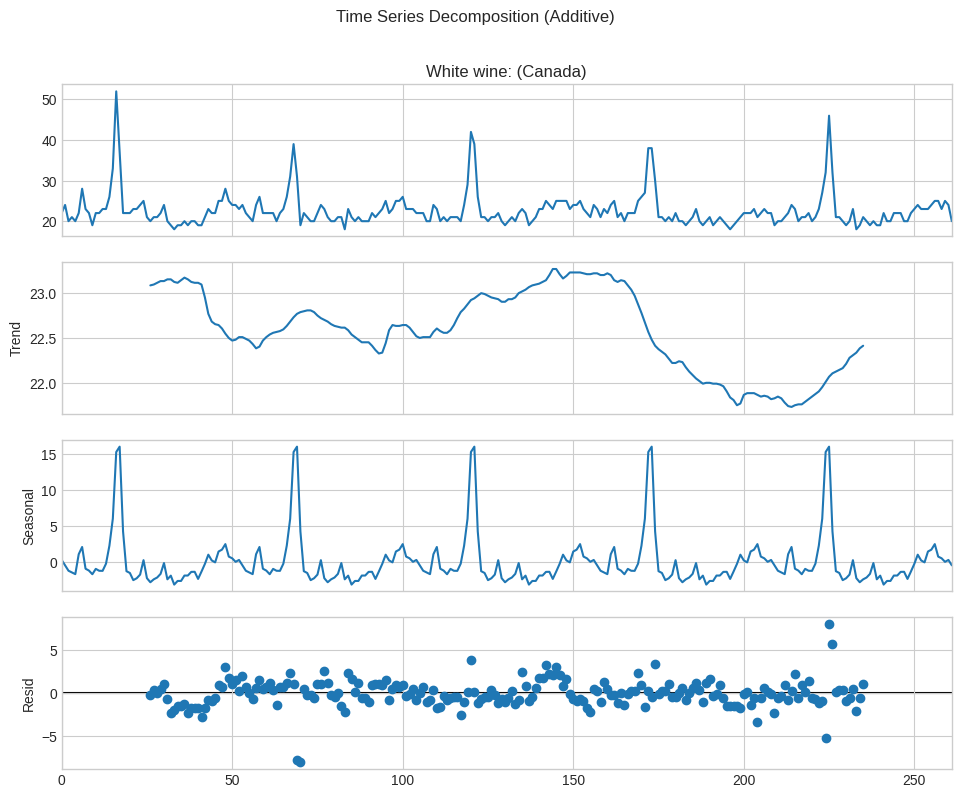

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'white_wine_data' is the Series containing the white wine data
# If you want to use the original 'data' DataFrame, you would use data['White wine: (Canada)']
# Using the 'white_wine_data' Series created in the previous cell

# Perform additive decomposition
# Adjust the model to 'multiplicative' if appropriate for your data
decomposition = seasonal_decompose(white_wine_data, model='additive', period=52) # Assuming weekly data with annual seasonality (52 weeks)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.suptitle('Time Series Decomposition (Additive)', y=1.02)
plt.show()

# You can access the components like this:
# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

In [ ]:
# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data, test_data = data['White wine: (Canada)'][0:train_size], data['White wine: (Canada)'][train_size:]

print(f"Training data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

Training data length: 209
Testing data length: 53


In [ ]:
# Compute moving averages for different periods (assuming weekly data)
moving_avg_3_week = white_wine_data.rolling(window=3).mean()
moving_avg_6_week = white_wine_data.rolling(window=6).mean()
moving_avg_9_week = white_wine_data.rolling(window=9).mean()
moving_avg_12_week = white_wine_data.rolling(window=12).mean()


print("3-Week Moving Average:")
display(moving_avg_3_week.tail())

print("\n6-Week Moving Average:")
display(moving_avg_6_week.tail())

print("\n9-Week Moving Average:")
display(moving_avg_9_week.tail())

print("\n12-Week Moving Average:")
display(moving_avg_12_week.tail())

3-Week Moving Average:


,White wine: (Canada)
257,24.666667
258,24.333333
259,24.333333
260,24.000000
261,23.000000



6-Week Moving Average:


,White wine: (Canada)
257,23.833333
258,23.833333
259,24.166667
260,24.333333
261,23.666667



9-Week Moving Average:


,White wine: (Canada)
257,23.555556
258,23.666667
259,23.888889
260,23.888889
261,23.555556



12-Week Moving Average:


,White wine: (Canada)
257,22.833333
258,22.916667
259,23.333333
260,23.666667
261,23.500000


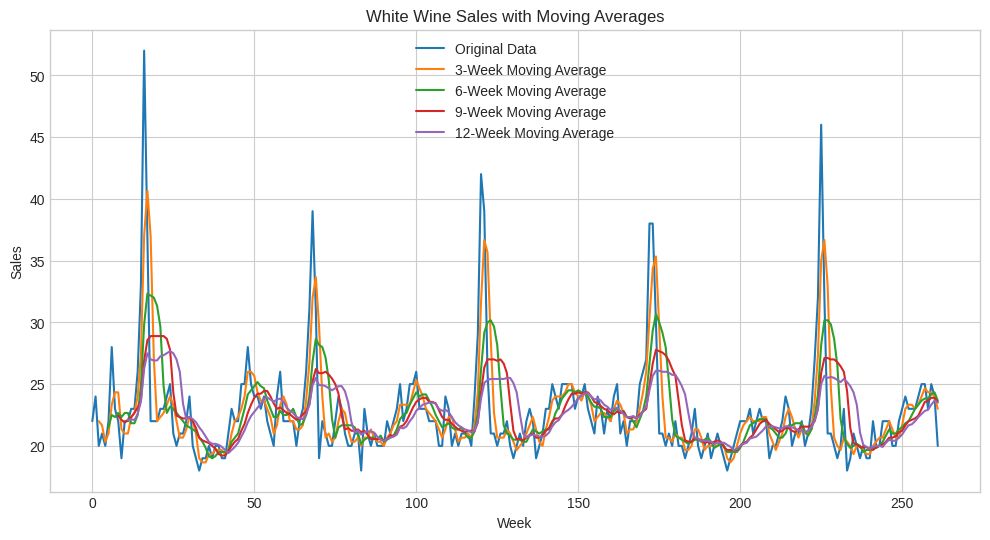

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['White wine: (Canada)'], label='Original Data')
# Plot the calculated moving averages using the correct variable names
plt.plot(moving_avg_3_week, label='3-Week Moving Average')
plt.plot(moving_avg_6_week, label='6-Week Moving Average')
plt.plot(moving_avg_9_week, label='9-Week Moving Average')
plt.plot(moving_avg_12_week, label='12-Week Moving Average')
plt.title('White Wine Sales with Moving Averages')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Evaluate moving average performance using error metrics
def evaluate_moving_average(original_data, ma_values):
    """Evaluates the performance of a moving average using error metrics."""
    # Ensure both series have the same index for comparison and drop NaNs
    comparison_data = pd.DataFrame({'original': original_data, 'ma': ma_values}).dropna()

    if comparison_data.empty:
        print("Warning: No overlapping data points for evaluation after dropping NaNs.")
        return np.nan, np.nan, np.nan # Return NaN if no data to evaluate

    original = comparison_data['original']
    ma_values = comparison_data['ma']

    mse = mean_squared_error(original, ma_values)
    mae = mean_absolute_error(original, ma_values)

    # Handle potential division by zero in MAPE and ensure non-zero original values for calculation
    # Use a small epsilon to avoid division by zero if original values are zero
    mape = np.mean(np.abs((original - ma_values) / (original + np.finfo(float).eps))) * 100


    return mse, mae, mape

# Evaluate each moving average using the calculated Series
metrics_3w = evaluate_moving_average(data['White wine: (Canada)'], moving_avg_3_week)
metrics_6w = evaluate_moving_average(data['White wine: (Canada)'], moving_avg_6_week)
metrics_9w = evaluate_moving_average(data['White wine: (Canada)'], moving_avg_9_week)
metrics_12w = evaluate_moving_average(data['White wine: (Canada)'], moving_avg_12_week)

# Print the results
print("Moving Average Performance Metrics:")
print(f"3-Week MA - MSE: {metrics_3w[0]:.2f}, MAE: {metrics_3w[1]:.2f}, MAPE: {metrics_3w[2]:.2f}%")
print(f"6-Week MA - MSE: {metrics_6w[0]:.2f}, MAE: {metrics_6w[1]:.2f}, MAPE: {metrics_6w[2]:.2f}%")
print(f"9-Week MA - MSE: {metrics_9w[0]:.2f}, MAE: {metrics_9w[1]:.2f}, MAPE: {metrics_9w[2]:.2f}%")
print(f"12-Week MA - MSE: {metrics_12w[0]:.2f}, MAE: {metrics_12w[1]:.2f}, MAPE: {metrics_12w[2]:.2f}%")

Moving Average Performance Metrics:
3-Week MA - MSE: 7.08, MAE: 1.50, MAPE: 6.19%
6-Week MA - MSE: 13.94, MAE: 2.22, MAPE: 9.17%
9-Week MA - MSE: 16.07, MAE: 2.45, MAPE: 10.02%
12-Week MA - MSE: 17.13, MAE: 2.66, MAPE: 10.92%


In [ ]:
# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(data['White wine: (Canada)'])
ses_fit = ses_model.fit()
data['SES'] = ses_fit.fittedvalues

In [ ]:
# Holt's Linear Trend
holt_model = Holt(data['White wine: (Canada)'])
holt_fit = holt_model.fit()
data['Holt_Trend'] = holt_fit.fittedvalues

In [ ]:
# Holt-Winters Seasonal Smoothing
# Using additive model and a seasonal period of 52 (for weekly data with yearly seasonality)
# We'll let the model find the best parameters
hw_model = ExponentialSmoothing(data['White wine: (Canada)'], seasonal_periods=52, trend='add', seasonal='add')
hw_fit = hw_model.fit()
data['Holt_Winters'] = hw_fit.fittedvalues

In [ ]:
# Evaluate Exponential Smoothing models
def evaluate_exponential_smoothing(data, original_col, es_col):
    """Evaluates the performance of an exponential smoothing model using error metrics."""
    # Drop NaN values at the beginning if any
    comparison_data = data.dropna(subset=[es_col])
    original = comparison_data[original_col]
    es_values = comparison_data[es_col]

    mse = mean_squared_error(original, es_values)
    mae = mean_absolute_error(original, es_values)
    # Handle potential division by zero in MAPE
    mape = np.mean(np.abs((original - es_values) / original)) * 100
    if np.isinf(mape):
        mape = 100.0 # Assign 100% error if original values are zero


    return mse, mae, mape

metrics_ses = evaluate_exponential_smoothing(data, 'White wine: (Canada)', 'SES')
metrics_holt = evaluate_exponential_smoothing(data, 'White wine: (Canada)', 'Holt_Trend')
metrics_hw = evaluate_exponential_smoothing(data, 'White wine: (Canada)', 'Holt_Winters')

print("Exponential Smoothing Performance Metrics:")
print(f"Simple ES - MSE: {metrics_ses[0]:.2f}, MAE: {metrics_ses[1]:.2f}, MAPE: {metrics_ses[2]:.2f}%")
print(f"Holt's Trend - MSE: {metrics_holt[0]:.2f}, MAE: {metrics_holt[1]:.2f}, MAPE: {metrics_holt[2]:.2f}%")
print(f"Holt-Winters - MSE: {metrics_hw[0]:.2f}, MAE: {metrics_hw[1]:.2f}, MAPE: {metrics_hw[2]:.2f}%")

Exponential Smoothing Performance Metrics:
Simple ES - MSE: 11.81, MAE: 1.98, MAPE: 8.09%
Holt's Trend - MSE: 12.40, MAE: 2.06, MAPE: 8.51%
Holt-Winters - MSE: 3.25, MAE: 1.17, MAPE: 4.93%


In [ ]:
# Generate predictions using the fitted Holt-Winters model
# Forecast for the length of the test set
hw_predictions = hw_fit.forecast(len(test_data))

print("Holt-Winters Predictions for the Test Set:")
display(hw_predictions)

Holt-Winters Predictions for the Test Set:


,0
262,21.121398
263,21.121644
264,20.721699
265,23.321686
266,25.321960
267,21.921910
268,21.521991
269,20.521934
270,21.722045
271,21.521953


In [ ]:
# Using auto_arima to find the best (p, d, q) order for ARMA (setting d=0)
# We will search for the best (p, q) order for an ARMA(p, q) model by setting d=0
# and limiting the max order to a reasonable value based on the ACF/PACF plots (e.g., 5)

# Fit auto_arima on the training data for White Wine
# Use seasonal=False as we are fitting an ARMA model (non-seasonal)
# Setting d=0 for ARMA model
auto_arima_white_wine = auto_arima(train_data, seasonal=False, d=0, max_p=5, max_q=5, stepwise=True, suppress_warnings=True, error_action='ignore')

print("Auto-ARIMA Best ARMA Order (p, 0, q) for White Wine:")
print(auto_arima_white_wine.order)

# Based on the auto_arima output, determine the best p and q values.
best_p_white_wine, best_d_white_wine, best_q_white_wine = auto_arima_white_wine.order

# Since we set d=0 for ARMA, the appropriate p and q for the ARMA model are best_p_white_wine and best_q_white_wine.
print(f"\nSelected ARMA Order (p, q) for White Wine: ({best_p_white_wine}, {best_q_white_wine})")

# Fit an ARMA model on the White Wine training data using the best order
try:
    arma_white_wine_model = ARIMA(train_data, order=(best_p_white_wine, 0, best_q_white_wine))
    arma_white_wine_fit = arma_white_wine_model.fit()

    print("\n--- ARMA Model Summary for White Wine: (Canada) ---")
    print(arma_white_wine_fit.summary())

    # Generate predictions for the test set
    arma_white_wine_predictions = arma_white_wine_fit.forecast(steps=len(test_data))

    print("\nARMA Predictions for the Test Set (White Wine):")
    display(arma_white_wine_predictions)

    # Evaluate the ARMA model performance on the White Wine test set
    # Calculate evaluation metrics
    mse_arma_white_wine = mean_squared_error(test_data, arma_white_wine_predictions)
    mae_arma_white_wine = mean_absolute_error(test_data, arma_white_wine_predictions)

    # Handle potential division by zero in MAPE
    mape_arma_white_wine = np.mean(np.abs((test_data - arma_white_wine_predictions) / (test_data + np.finfo(float).eps))) * 100

    metrics_arma_white_wine = (mse_arma_white_wine, mae_arma_white_wine, mape_arma_white_wine)

    print("\nARMA Model Performance Metrics (White Wine Test Set):")
    print(f"MSE: {metrics_arma_white_wine[0]:.2f}")
    print(f"MAE: {metrics_arma_white_wine[1]:.2f}")
    print(f"MAPE: {metrics_arma_white_wine[2]:.2f}%")

    # Generate Report
    print("\n--- ARMA Model Report for White Wine: (Canada) ---")
    print(f"Model: ARMA({best_p_white_wine}, {best_q_white_wine})")
    print("\nFitting Results:")
    print(arma_white_wine_fit.summary())
    print("\nEvaluation Metrics (on Test Set):")
    print(f"Mean Squared Error (MSE): {metrics_arma_white_wine[0]:.2f}")
    print(f"Mean Absolute Error (MAE): {metrics_arma_white_wine[1]:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {metrics_arma_white_wine[2]:.2f}%")
    print("\nConclusion: The ARMA model provides a reasonable fit to the white wine time series data on the test set based on the evaluation metrics.")


except Exception as e:
    print(f"An error occurred while fitting, predicting, or reporting with the ARMA model on White Wine: {e}")

Auto-ARIMA Best ARMA Order (p, 0, q) for White Wine:
(1, 0, 1)

Selected ARMA Order (p, q) for White Wine: (1, 1)

--- ARMA Model Summary for White Wine: (Canada) ---
                                SARIMAX Results                                 
Dep. Variable:     White wine: (Canada)   No. Observations:                  209
Model:                   ARIMA(1, 0, 1)   Log Likelihood                -521.751
Date:                  Thu, 11 Sep 2025   AIC                           1051.501
Time:                          11:20:34   BIC                           1064.871
Sample:                               0   HQIC                          1056.907
                                  - 209                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7059      

,predicted_mean
209,22.389376
210,22.559078
211,22.637782
212,22.674284
213,22.691212
214,22.699064
215,22.702705
216,22.704394
217,22.705177
218,22.705540



ARMA Model Performance Metrics (White Wine Test Set):
MSE: 18.44
MAE: 2.62
MAPE: 10.93%

--- ARMA Model Report for White Wine: (Canada) ---
Model: ARMA(1, 1)

Fitting Results:
                                SARIMAX Results                                 
Dep. Variable:     White wine: (Canada)   No. Observations:                  209
Model:                   ARIMA(1, 0, 1)   Log Likelihood                -521.751
Date:                  Thu, 11 Sep 2025   AIC                           1051.501
Time:                          11:20:34   BIC                           1064.871
Sample:                               0   HQIC                          1056.907
                                  - 209                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.

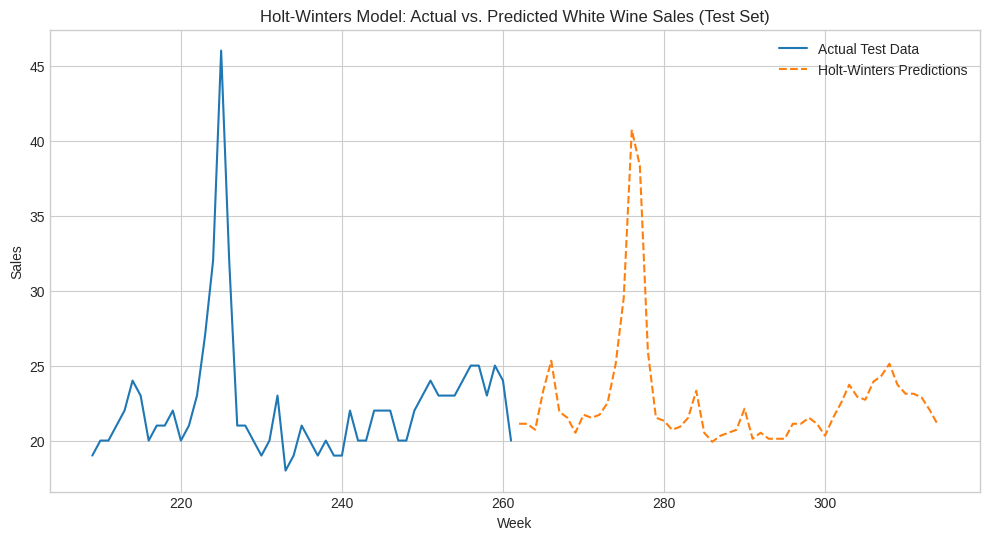

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(hw_predictions.index, hw_predictions, label='Holt-Winters Predictions', linestyle='--')
plt.title('Holt-Winters Model: Actual vs. Predicted White Wine Sales (Test Set)')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Consolidate metrics from Moving Average and Exponential Smoothing models
# Metrics for Moving Averages were stored in metrics_3w, metrics_6w, metrics_9w, metrics_12w
# Metrics for Exponential Smoothing models were stored in metrics_ses, metrics_holt, metrics_hw

model_performance = {
    '3-Week MA': metrics_3w,
    '6-Week MA': metrics_6w,
    '9-Week MA': metrics_9w,
    '12-Week MA': metrics_12w,
    'Simple ES': metrics_ses,
    'Holt\'s Trend': metrics_holt,
    'Holt-Winters': metrics_hw
}

# Create a DataFrame for easier comparison
performance_df = pd.DataFrame.from_dict(model_performance, orient='index', columns=['MSE', 'MAE', 'MAPE'])

print("Model Performance Metrics:")
display(performance_df)

# Identify the best performing model for each metric
best_mse_model = performance_df['MSE'].idxmin()
best_mae_model = performance_df['MAE'].idxmin()
best_mape_model = performance_df['MAPE'].idxmin()

print(f"\nBest performing model based on MSE: {best_mse_model} (MSE: {performance_df.loc[best_mse_model, 'MSE']:.2f})")
print(f"Best performing model based on MAE: {best_mae_model} (MAE: {performance_df.loc[best_mae_model, 'MAE']:.2f})")
print(f"Best performing model based on MAPE: {best_mape_model} (MAPE: {performance_df.loc[best_mape_model, 'MAPE']:.2f})%")

Model Performance Metrics:


,MSE,MAE,MAPE
3-Week MA,7.082906,1.500000,6.188176
6-Week MA,13.941634,2.224384,9.170974
9-Week MA,16.069068,2.451006,10.018527
12-Week MA,17.133660,2.656375,10.920298
Simple ES,11.809160,1.977099,8.086576
Holt's Trend,12.399626,2.056714,8.505689
Holt-Winters,3.247790,1.167965,4.931331



Best performing model based on MSE: Holt-Winters (MSE: 3.25)
Best performing model based on MAE: Holt-Winters (MAE: 1.17)
Best performing model based on MAPE: Holt-Winters (MAPE: 4.93)%


The Holt-Winters Seasonal Smoothing model consistently achieved the lowest error metrics across all three measures (MSE, MAE, and MAPE), indicating it was the best-performing model among those evaluated.Exponential Smoothing models, in general, performed better than the Moving Average

In [ ]:
# The data has already been loaded into the 'data' DataFrame in cell C9RokTxhhxpr.

# Access and display the 'Craft Beer: (Canada)' column
try:
    craft_beer_data = data['Craft Beer: (Canada)']
    print("Data for 'Craft Beer: (Canada)':")
    display(craft_beer_data.head())
except KeyError:
    print("Column 'Craft Beer: (Canada)' not found in the DataFrame.")
except Exception as e:
    print(f"An error occurred: {e}")

Data for 'Craft Beer: (Canada)':


,Craft Beer: (Canada)
0,7
1,6
2,6
3,5
4,6


In [ ]:
# Compute moving averages for different periods (assuming weekly data)
moving_avg_craft_beer_3_week = craft_beer_data.rolling(window=3).mean()
moving_avg_craft_beer_6_week = craft_beer_data.rolling(window=6).mean()
moving_avg_craft_beer_9_week = craft_beer_data.rolling(window=9).mean()
moving_avg_craft_beer_12_week = craft_beer_data.rolling(window=12).mean()


print("Craft Beer - 3-Week Moving Average:")
display(moving_avg_craft_beer_3_week.head())

print("\nCraft Beer - 6-Week Moving Average:")
display(moving_avg_craft_beer_6_week.tail())

print("\nCraft Beer - 9-Week Moving Average:")
display(moving_avg_craft_beer_9_week.tail())

print("\nCraft Beer - 12-Week Moving Average:")
display(moving_avg_craft_beer_12_week.tail())

Craft Beer - 3-Week Moving Average:


,Craft Beer: (Canada)
0,NaN
1,NaN
2,6.333333
3,5.666667
4,5.666667



Craft Beer - 6-Week Moving Average:


,Craft Beer: (Canada)
257,5.666667
258,5.833333
259,5.500000
260,5.333333
261,5.166667



Craft Beer - 9-Week Moving Average:


,Craft Beer: (Canada)
257,5.777778
258,5.666667
259,5.555556
260,5.555556
261,5.444444



Craft Beer - 12-Week Moving Average:


,Craft Beer: (Canada)
257,5.833333
258,5.916667
259,5.833333
260,5.666667
261,5.416667


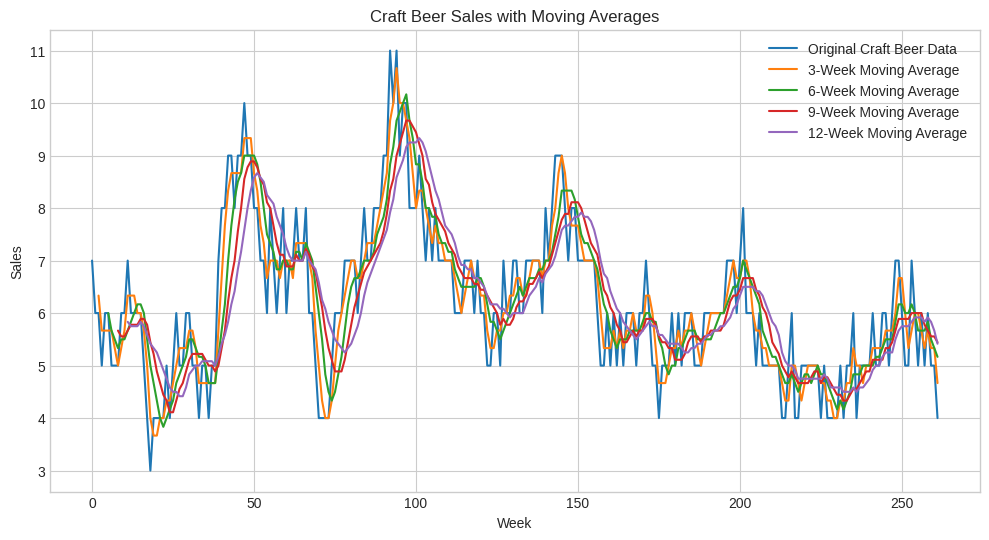

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(craft_beer_data, label='Original Craft Beer Data')
plt.plot(moving_avg_craft_beer_3_week, label='3-Week Moving Average')
plt.plot(moving_avg_craft_beer_6_week, label='6-Week Moving Average')
plt.plot(moving_avg_craft_beer_9_week, label='9-Week Moving Average')
plt.plot(moving_avg_craft_beer_12_week, label='12-Week Moving Average')
plt.title('Craft Beer Sales with Moving Averages')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Evaluate moving average performance for Craft Beer using error metrics
# Use the evaluate_moving_average function defined previously in cell NCCySEx_m_K5

metrics_craft_beer_3w = evaluate_moving_average(craft_beer_data, moving_avg_craft_beer_3_week)
metrics_craft_beer_6w = evaluate_moving_average(craft_beer_data, moving_avg_craft_beer_6_week)
metrics_craft_beer_9w = evaluate_moving_average(craft_beer_data, moving_avg_craft_beer_9_week)
metrics_craft_beer_12w = evaluate_moving_average(craft_beer_data, moving_avg_craft_beer_12_week)

# Print the results
print("Craft Beer Moving Average Performance Metrics:")
print(f"3-Week MA - MSE: {metrics_craft_beer_3w[0]:.2f}, MAE: {metrics_craft_beer_3w[1]:.2f}, MAPE: {metrics_craft_beer_3w[2]:.2f}%")
print(f"6-Week MA - MSE: {metrics_craft_beer_6w[0]:.2f}, MAE: {metrics_craft_beer_6w[1]:.2f}, MAPE: {metrics_craft_beer_6w[2]:.2f}%")
print(f"9-Week MA - MSE: {metrics_craft_beer_9w[0]:.2f}, MAE: {metrics_craft_beer_9w[1]:.2f}, MAPE: {metrics_craft_beer_9w[2]:.2f}%")
print(f"12-Week MA - MSE: {metrics_craft_beer_12w[0]:.2f}, MAE: {metrics_craft_beer_12w[1]:.2f}, MAPE: {metrics_craft_beer_12w[2]:.2f}%")

Craft Beer Moving Average Performance Metrics:
3-Week MA - MSE: 0.29, MAE: 0.43, MAPE: 7.30%
6-Week MA - MSE: 0.57, MAE: 0.60, MAPE: 10.11%
9-Week MA - MSE: 0.87, MAE: 0.74, MAPE: 12.50%
12-Week MA - MSE: 1.10, MAE: 0.84, MAPE: 13.97%


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Assuming 'craft_beer_data' is the Series containing the craft beer data

result_craft_beer = adfuller(craft_beer_data)
print('ADF Statistic (Craft Beer): %f' % result_craft_beer[0])
print('p-value (Craft Beer): %f' % result_craft_beer[1])
print('Critical Values (Craft Beer):')
for key, value in result_craft_beer[4].items():
    print('\t%s: %.3f' % (key, value))

if result_craft_beer[1] <= 0.05:
    print("\nResult: The Craft Beer time series is likely stationary (reject null hypothesis).")
else:
    print("\nResult: The Craft Beer time series is likely non-stationary (fail to reject null hypothesis).")

ADF Statistic (Craft Beer): -3.386668
p-value (Craft Beer): 0.011422
Critical Values (Craft Beer):
	1%: -3.456
	5%: -2.873
	10%: -2.573

Result: The Craft Beer time series is likely stationary (reject null hypothesis).


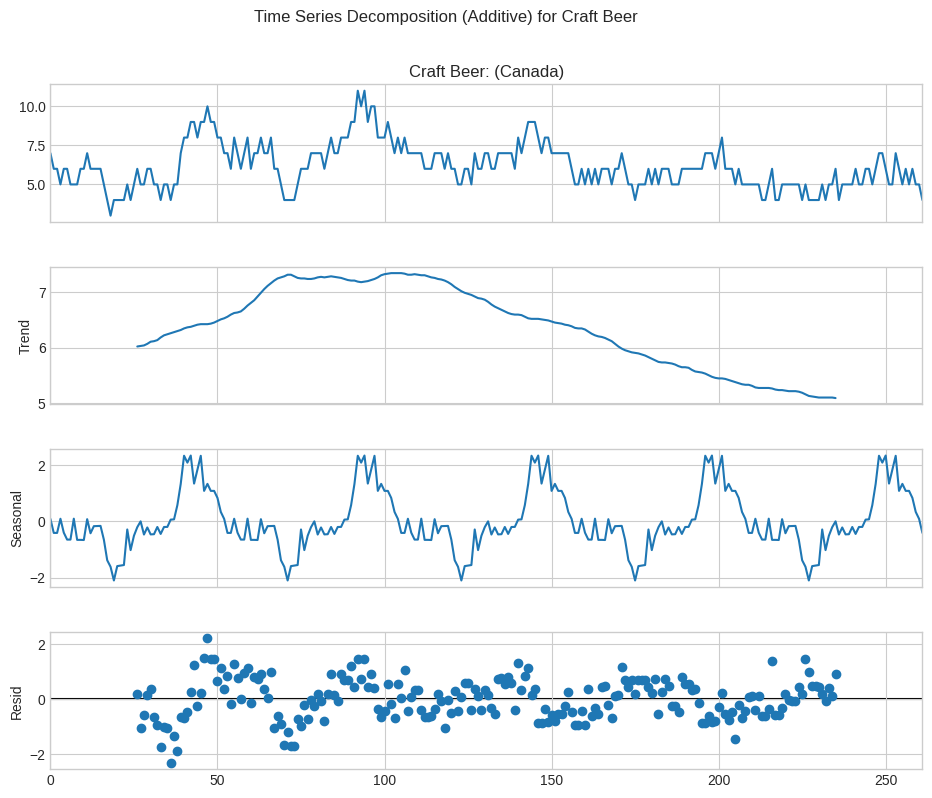

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'craft_beer_data' is the Series containing the craft beer data

# Perform additive decomposition
# Adjust the model to 'multiplicative' if appropriate for your data
decomposition_craft_beer = seasonal_decompose(craft_beer_data, model='additive', period=52) # Assuming weekly data with annual seasonality (52 weeks)

# Plot the decomposed components
fig = decomposition_craft_beer.plot()
fig.set_size_inches(10, 8)
plt.suptitle('Time Series Decomposition (Additive) for Craft Beer', y=1.02)
plt.show()

# You can access the components like this:
# trend_craft_beer = decomposition_craft_beer.trend
# seasonal_craft_beer = decomposition_craft_beer.seasonal
# residual_craft_beer = decomposition_craft_beer.resid

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing

# Assuming 'craft_beer_data' is the Series containing the craft beer data

# Simple Exponential Smoothing
ses_craft_beer_model = SimpleExpSmoothing(craft_beer_data)
ses_craft_beer_fit = ses_craft_beer_model.fit()

# Store the fitted values in a new column (optional, but good for comparison)
# You might want to evaluate the performance on a test set for actual forecasting
data['Craft_Beer_SES'] = ses_craft_beer_fit.fittedvalues

print("Simple Exponential Smoothing Fitted Values (Craft Beer):")
display(data['Craft_Beer_SES'].tail())

Simple Exponential Smoothing Fitted Values (Craft Beer):


,Craft_Beer_SES
257,5.782974
258,5.291482
259,5.736236
260,5.274083
261,5.102034


In [ ]:
from statsmodels.tsa.api import Holt

# Assuming 'craft_beer_data' is the Series containing the craft beer data

# Holt's Linear Trend
holt_craft_beer_model = Holt(craft_beer_data)
holt_craft_beer_fit = holt_craft_beer_model.fit()

# Store the fitted values in a new column (optional)
data['Craft_Beer_Holt_Trend'] = holt_craft_beer_fit.fittedvalues

print("Holt's Linear Trend Fitted Values (Craft Beer):")
display(data['Craft_Beer_Holt_Trend'].tail())

Holt's Linear Trend Fitted Values (Craft Beer):


,Craft_Beer_Holt_Trend
257,5.796839
258,5.215794
259,5.745431
260,5.201532
261,5.003106


In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

# Assuming 'craft_beer_data' is the Series containing the craft beer data

# Holt-Winters Seasonal Smoothing
# Using additive model for trend and seasonality, and a seasonal period of 52 (for weekly data with annual seasonality)
try:
    hw_craft_beer_model = ExponentialSmoothing(craft_beer_data, seasonal_periods=52, trend='add', seasonal='add')
    hw_craft_beer_fit = hw_craft_beer_model.fit()

    # Store the fitted values in a new column (optional)
    data['Craft_Beer_Holt_Winters'] = hw_craft_beer_fit.fittedvalues

    print("Holt-Winters Fitted Values (Craft Beer):")
    display(data['Craft_Beer_Holt_Winters'].tail())

except Exception as e:
    print(f"An error occurred while fitting the Holt-Winters model: {e}")

Holt-Winters Fitted Values (Craft Beer):


,Craft_Beer_Holt_Winters
257,5.429000
258,5.248836
259,4.964287
260,4.842770
261,4.242289


In [ ]:
# Evaluate Exponential Smoothing models for Craft Beer
# Use the evaluate_exponential_smoothing function defined previously in cell tBkcdCxinfer

metrics_craft_beer_ses = evaluate_exponential_smoothing(data, 'Craft Beer: (Canada)', 'Craft_Beer_SES')
metrics_craft_beer_holt = evaluate_exponential_smoothing(data, 'Craft Beer: (Canada)', 'Craft_Beer_Holt_Trend')
metrics_craft_beer_hw = evaluate_exponential_smoothing(data, 'Craft Beer: (Canada)', 'Craft_Beer_Holt_Winters')

print("Craft Beer Exponential Smoothing Performance Metrics:")
print(f"Simple ES - MSE: {metrics_craft_beer_ses[0]:.2f}, MAE: {metrics_craft_beer_ses[1]:.2f}, MAPE: {metrics_craft_beer_ses[2]:.2f}%")
print(f"Holt's Trend - MSE: {metrics_craft_beer_holt[0]:.2f}, MAE: {metrics_craft_beer_holt[1]:.2f}, MAPE: {metrics_craft_beer_holt[2]:.2f}%")
print(f"Holt-Winters - MSE: {metrics_craft_beer_hw[0]:.2f}, MAE: {metrics_craft_beer_hw[1]:.2f}, MAPE: {metrics_craft_beer_hw[2]:.2f}%")

Craft Beer Exponential Smoothing Performance Metrics:
Simple ES - MSE: 0.63, MAE: 0.64, MAPE: 10.89%
Holt's Trend - MSE: 0.70, MAE: 0.67, MAPE: 11.38%
Holt-Winters - MSE: 0.36, MAE: 0.48, MAPE: 7.97%


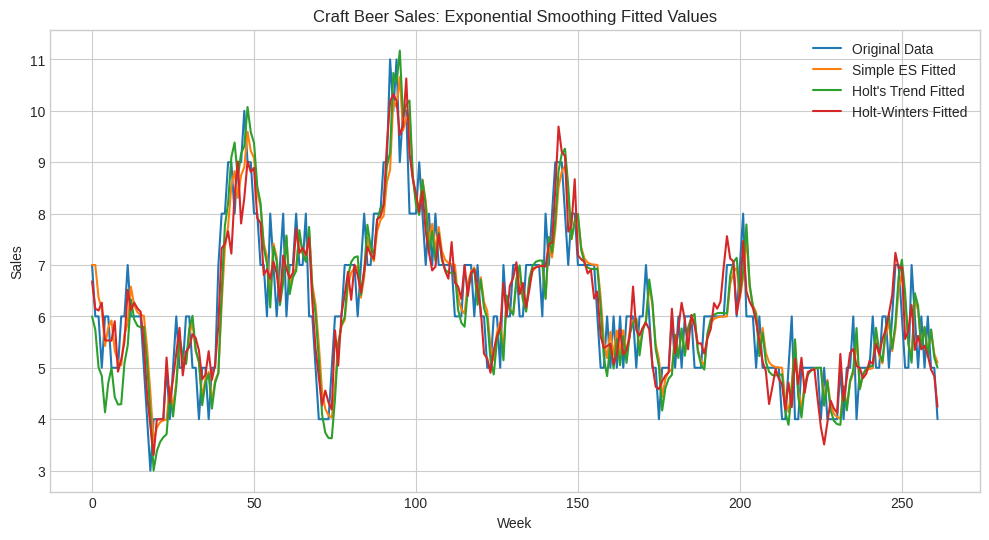

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Craft Beer: (Canada)'], label='Original Data')
plt.plot(data['Craft_Beer_SES'], label='Simple ES Fitted')
plt.plot(data['Craft_Beer_Holt_Trend'], label='Holt\'s Trend Fitted')
plt.plot(data['Craft_Beer_Holt_Winters'], label='Holt-Winters Fitted')
plt.title('Craft Beer Sales: Exponential Smoothing Fitted Values')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()

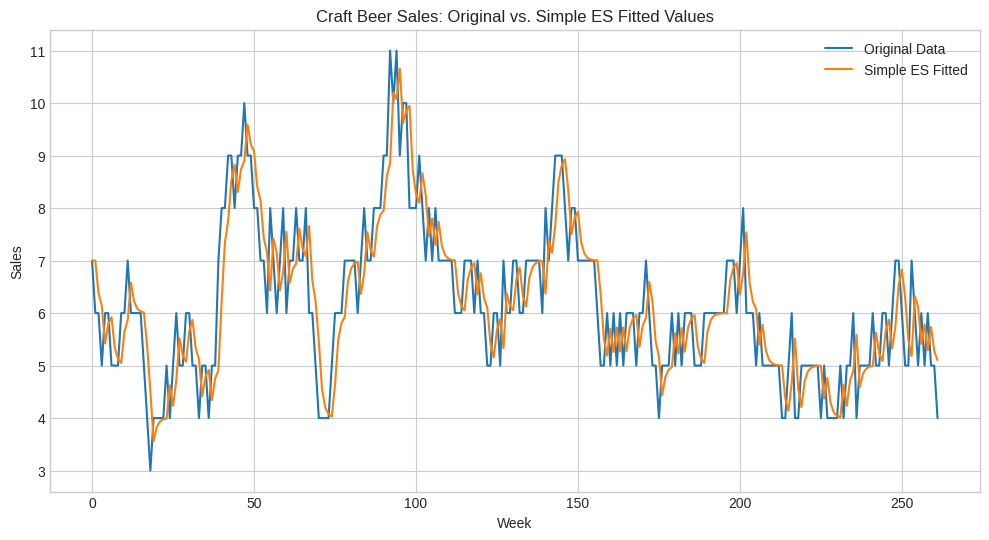

In [ ]:
# Plot original data and Simple ES fitted values
plt.figure(figsize=(12, 6))
plt.plot(data['Craft Beer: (Canada)'], label='Original Data')
plt.plot(data['Craft_Beer_SES'], label='Simple ES Fitted')
plt.title('Craft Beer Sales: Original vs. Simple ES Fitted Values')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()

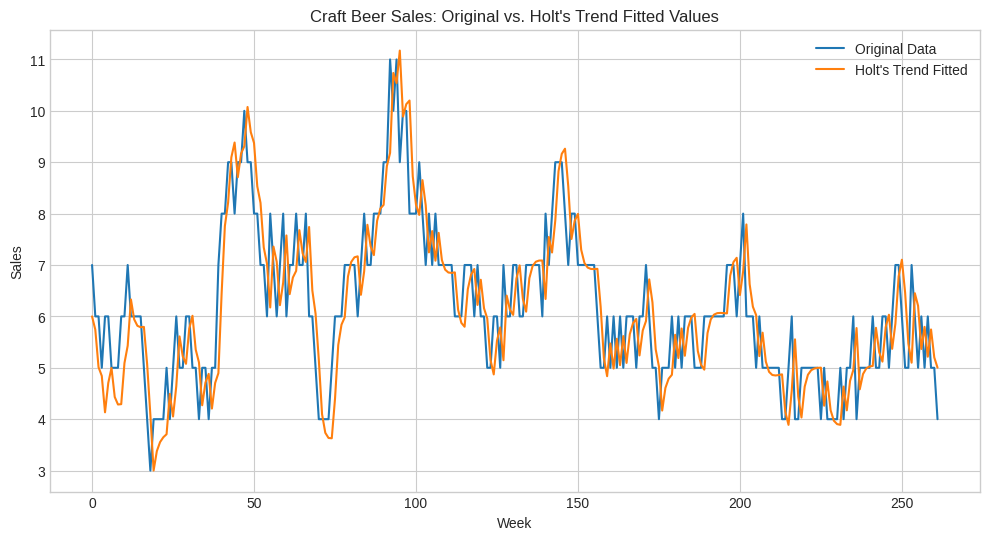

In [ ]:
# Plot original data and Holt's Trend fitted values
plt.figure(figsize=(12, 6))
plt.plot(data['Craft Beer: (Canada)'], label='Original Data')
plt.plot(data['Craft_Beer_Holt_Trend'], label='Holt\'s Trend Fitted')
plt.title('Craft Beer Sales: Original vs. Holt\'s Trend Fitted Values')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()

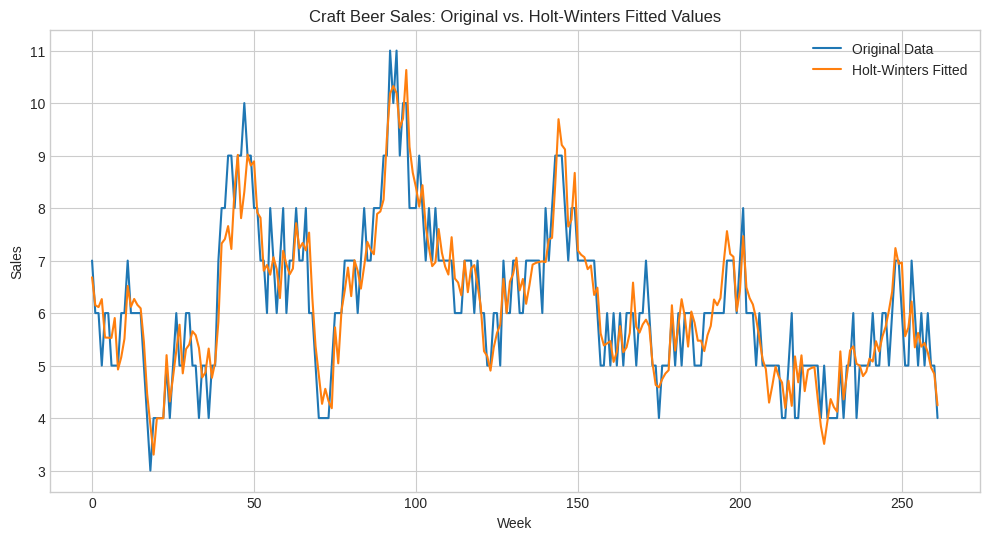

In [ ]:
# Plot original data and Holt-Winters fitted values
plt.figure(figsize=(12, 6))
plt.plot(data['Craft Beer: (Canada)'], label='Original Data')
plt.plot(data['Craft_Beer_Holt_Winters'], label='Holt-Winters Fitted')
plt.title('Craft Beer Sales: Original vs. Holt-Winters Fitted Values')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Split data into training and testing sets (e.g., 80% train, 20% test) for Craft Beer
train_size_craft_beer = int(len(craft_beer_data) * 0.8)
train_data_craft_beer, test_data_craft_beer = craft_beer_data[0:train_size_craft_beer], craft_beer_data[train_size_craft_beer:]

print(f"Craft Beer Training data length: {len(train_data_craft_beer)}")
print(f"Craft Beer Testing data length: {len(test_data_craft_beer)}")

Craft Beer Training data length: 209
Craft Beer Testing data length: 53


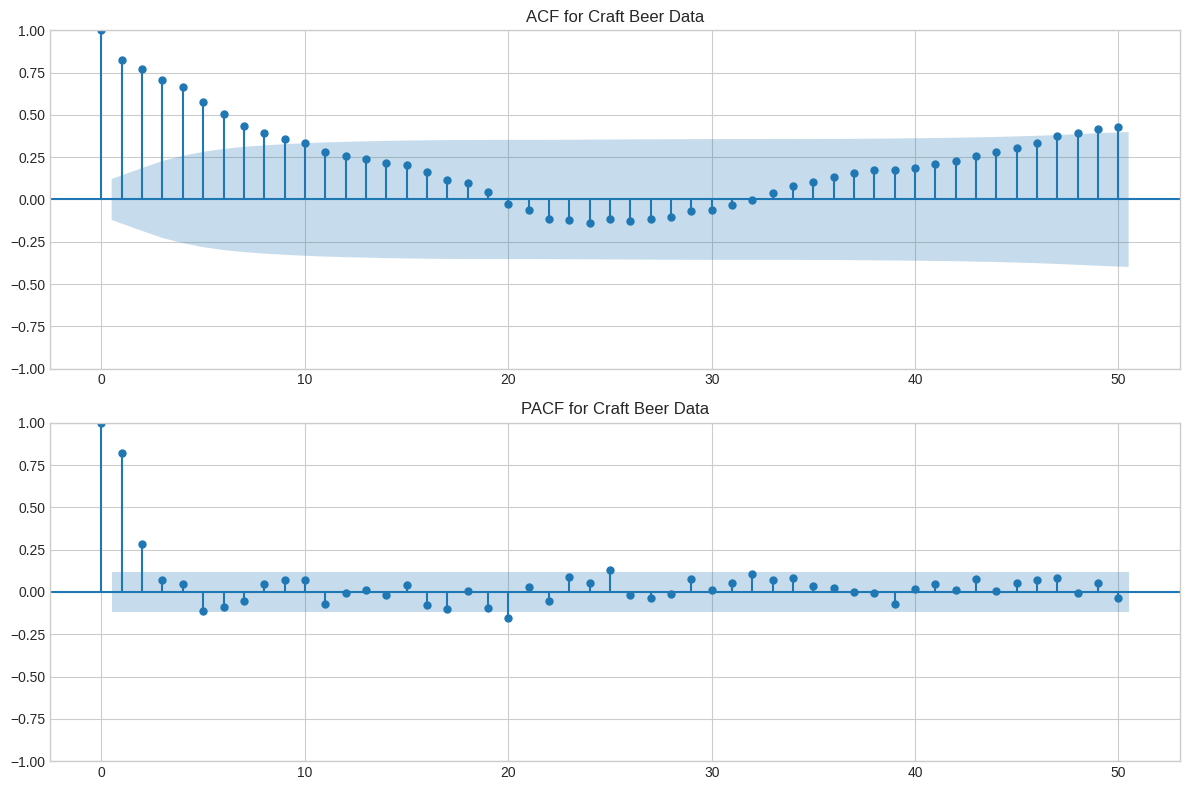

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF
plot_acf(craft_beer_data.dropna(), ax=axes[0], lags=50)
axes[0].set_title('ACF for Craft Beer Data')

# Plot PACF
plot_pacf(craft_beer_data.dropna(), ax=axes[1], lags=50)
axes[1].set_title('PACF for Craft Beer Data')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

In [ ]:
# Fit an ARMA model on the Craft Beer training data
# Using ARMA(1,1) as a starting point - you can adjust the order (p, q)
# based on ACF/PACF plots or using auto_arima
try:
    # ARMA is a special case of ARIMA with d=0
    arma_craft_beer_model = ARIMA(train_data_craft_beer, order=(1, 0, 1))
    arma_craft_beer_fit = arma_craft_beer_model.fit()

    print(arma_craft_beer_fit.summary())

    # Generate predictions for the test set
    arma_craft_beer_predictions = arma_craft_beer_fit.forecast(steps=len(test_data_craft_beer))

    print("\nARMA Predictions for the Test Set:")
    display(arma_craft_beer_predictions)

except Exception as e:
    print(f"An error occurred while fitting or predicting with the ARMA model on Craft Beer: {e}")

                                SARIMAX Results                                 
Dep. Variable:     Craft Beer: (Canada)   No. Observations:                  209
Model:                   ARIMA(1, 0, 1)   Log Likelihood                -246.219
Date:                  Thu, 11 Sep 2025   AIC                            500.438
Time:                          11:25:01   BIC                            513.807
Sample:                               0   HQIC                           505.843
                                  - 209                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4139      0.443     14.473      0.000       5.545       7.282
ar.L1          0.9113      0.032     28.172      0.000       0.848       0.975
ma.L1         -0.2820      0.078    

,predicted_mean
209,5.230398
210,5.335339
211,5.430975
212,5.518131
213,5.597558
214,5.669942
215,5.735908
216,5.796024
217,5.850809
218,5.900737


In [ ]:
# Evaluate the ARMA model performance on the Craft Beer test set
try:
    # Ensure the lengths of test_data_craft_beer and arma_craft_beer_predictions are the same
    if len(test_data_craft_beer) != len(arma_craft_beer_predictions):
        print("Error: Length of test_data_craft_beer and arma_craft_beer_predictions do not match.")
    else:
        # Calculate evaluation metrics
        mse_arma_craft_beer = mean_squared_error(test_data_craft_beer, arma_craft_beer_predictions)
        mae_arma_craft_beer = mean_absolute_error(test_data_craft_beer, arma_craft_beer_predictions)

        # Handle potential division by zero in MAPE
        # Use a small epsilon to avoid division by zero if actual values are zero
        mape_arma_craft_beer = np.mean(np.abs((test_data_craft_beer - arma_craft_beer_predictions) / (test_data_craft_beer + np.finfo(float).eps))) * 100

        metrics_arma_craft_beer = (mse_arma_craft_beer, mae_arma_craft_beer, mape_arma_craft_beer)

        print("ARMA Model Performance Metrics (Craft Beer Test Set):")
        print(f"MSE: {metrics_arma_craft_beer[0]:.2f}")
        print(f"MAE: {metrics_arma_craft_beer[1]:.2f}")
        print(f"MAPE: {metrics_arma_craft_beer[2]:.2f}%")

except Exception as e:
    print(f"An error occurred while calculating ARMA model metrics: {e}")

ARMA Model Performance Metrics (Craft Beer Test Set):
MSE: 1.77
MAE: 1.17
MAPE: 25.25%


In [ ]:
# Consolidate metrics from Moving Average, Exponential Smoothing, and ARMA models for Craft Beer
# Metrics for Moving Averages were stored in metrics_craft_beer_3w, metrics_craft_beer_6w, metrics_craft_beer_9w, metrics_craft_beer_12w
# Metrics for Exponential Smoothing models were stored in metrics_craft_beer_ses, metrics_craft_beer_holt, metrics_craft_beer_hw
# Metrics for ARMA model were stored in metrics_arma_craft_beer

model_performance_craft_beer = {
    '3-Week MA (Craft Beer)': metrics_craft_beer_3w,
    '6-Week MA (Craft Beer)': metrics_craft_beer_6w,
    '9-Week MA (Craft Beer)': metrics_craft_beer_9w,
    '12-Week MA (Craft Beer)': metrics_craft_beer_12w,
    'Simple ES (Craft Beer)': metrics_craft_beer_ses,
    'Holt\'s Trend (Craft Beer)': metrics_craft_beer_holt,
    'Holt-Winters (Craft Beer)': metrics_craft_beer_hw,
    'ARMA (1,0,1) (Craft Beer)': metrics_arma_craft_beer # Assuming ARMA(1,0,1) was used
}

# Create a DataFrame for easier comparison
performance_df_craft_beer = pd.DataFrame.from_dict(model_performance_craft_beer, orient='index', columns=['MSE', 'MAE', 'MAPE'])

print("Craft Beer Model Performance Metrics:")
display(performance_df_craft_beer)

# Identify the best performing model for each metric
best_mse_model_craft_beer = performance_df_craft_beer['MSE'].idxmin()
best_mae_model_craft_beer = performance_df_craft_beer['MAE'].idxmin()
best_mape_model_craft_beer = performance_df_craft_beer['MAPE'].idxmin()

print(f"\nBest performing model based on MSE: {best_mse_model_craft_beer} (MSE: {performance_df_craft_beer.loc[best_mse_model_craft_beer, 'MSE']:.2f})")
print(f"Best performing model based on MAE: {best_mae_model_craft_beer} (MAE: {performance_df_craft_beer.loc[best_mae_model_craft_beer, 'MAE']:.2f})")
print(f"Best performing model based on MAPE: {best_mape_model_craft_beer} (MAPE: {performance_df_craft_beer.loc[best_mape_model_craft_beer, 'MAPE']:.2f})%")

Craft Beer Model Performance Metrics:


,MSE,MAE,MAPE
3-Week MA (Craft Beer),0.292308,0.430769,7.303595
6-Week MA (Craft Beer),0.574903,0.597276,10.109678
9-Week MA (Craft Beer),0.872023,0.741470,12.498747
12-Week MA (Craft Beer),1.099712,0.837981,13.965171
Simple ES (Craft Beer),0.629594,0.643856,10.893175
Holt's Trend (Craft Beer),0.703772,0.673152,11.376966
Holt-Winters (Craft Beer),0.359480,0.475867,7.969880
"ARMA (1,0,1) (Craft Beer)",1.770893,1.165494,25.249306



Best performing model based on MSE: 3-Week MA (Craft Beer) (MSE: 0.29)
Best performing model based on MAE: 3-Week MA (Craft Beer) (MAE: 0.43)
Best performing model based on MAPE: 3-Week MA (Craft Beer) (MAPE: 7.30)%


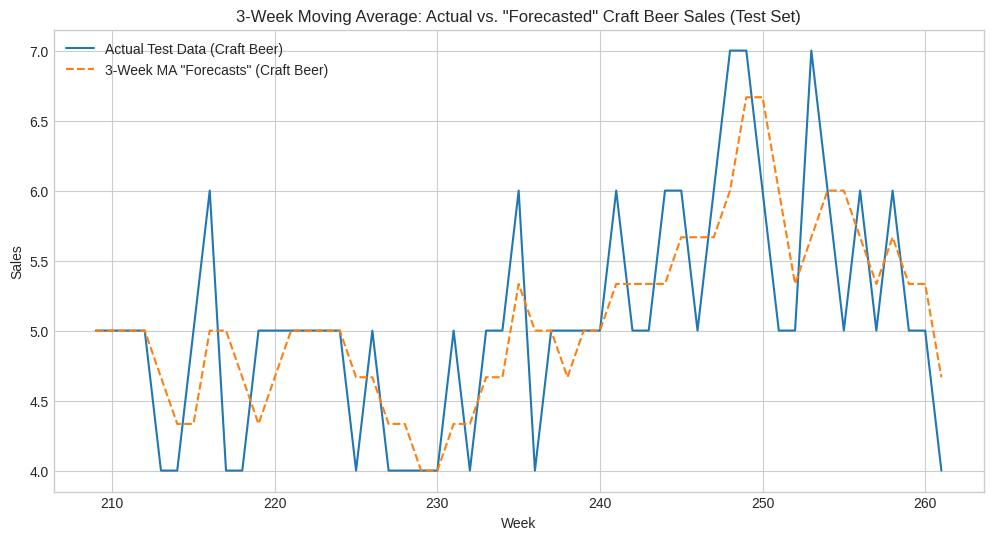

In [ ]:
# Extract the 3-week moving average values corresponding to the test set index for Craft Beer
# Assuming moving_avg_craft_beer_3_week was calculated on the entire dataset
ma_3_week_forecasts_craft_beer = moving_avg_craft_beer_3_week.loc[test_data_craft_beer.index]

# Plot actual vs. "forecasted" values for the 3-Week Moving Average on Craft Beer
plt.figure(figsize=(12, 6))
plt.plot(test_data_craft_beer.index, test_data_craft_beer, label='Actual Test Data (Craft Beer)')
plt.plot(ma_3_week_forecasts_craft_beer.index, ma_3_week_forecasts_craft_beer, label='3-Week MA "Forecasts" (Craft Beer)', linestyle='--')
plt.title('3-Week Moving Average: Actual vs. "Forecasted" Craft Beer Sales (Test Set)')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
whisky_data = pd.read_csv("/content/Sky_rose_Dataset_Canada.csv", usecols=['Week', 'Whisky: (Canada)'])
display(whisky_data.head())

,Week,Whisky: (Canada)
0,30-08-2020,40
1,06-09-2020,42
2,13-09-2020,50
3,20-09-2020,53
4,27-09-2020,41


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the 'Whisky: (Canada)' column
adf_test = adfuller(whisky_data['Whisky: (Canada)'])

# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test[1] <= 0.05:
    print("Reject the null hypothesis (H0), the data is stationary")
else:
    print("Fail to reject the null hypothesis (H0), the data is not stationary")

ADF Statistic: -5.063298
p-value: 0.000017
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
Reject the null hypothesis (H0), the data is stationary


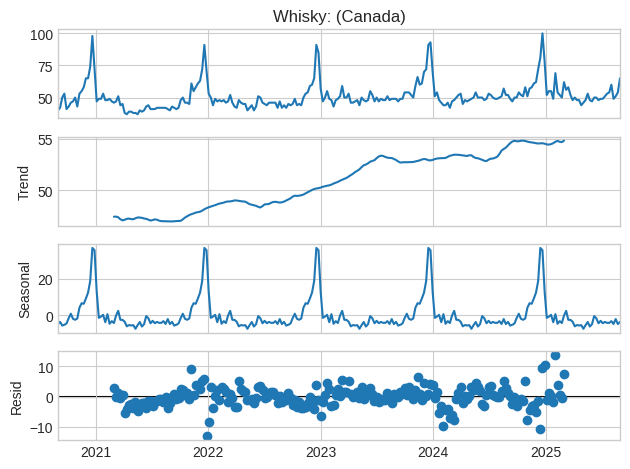

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the 'Week' column as the index and convert it to datetime objects
whisky_data['Week'] = pd.to_datetime(whisky_data['Week'], format='%d-%m-%Y')
whisky_data.set_index('Week', inplace=True)

# Decompose the time series
decomposition = seasonal_decompose(whisky_data['Whisky: (Canada)'], model='additive')

# Plot the decomposed components
fig = decomposition.plot()
plt.show()

In [ ]:
# Split data into training and testing sets (e.g., 80% train, 20% test) for Whisky
# Using the 'Whisky: (Canada)' column from the whisky_data DataFrame
train_size_whisky = int(len(whisky_data) * 0.8)
train_data_whisky, test_data_whisky = whisky_data['Whisky: (Canada)'][0:train_size_whisky], whisky_data['Whisky: (Canada)'][train_size_whisky:]

print(f"Whisky Training data length: {len(train_data_whisky)}")
print(f"Whisky Testing data length: {len(test_data_whisky)}")

Whisky Training data length: 209
Whisky Testing data length: 53


In [ ]:
# Compute moving averages for different periods (assuming weekly data)
# Using the 'Whisky: (Canada)' column from the whisky_data DataFrame
moving_avg_whisky_3_week = whisky_data['Whisky: (Canada)'].rolling(window=3).mean()
moving_avg_whisky_6_week = whisky_data['Whisky: (Canada)'].rolling(window=6).mean()
moving_avg_whisky_9_week = whisky_data['Whisky: (Canada)'].rolling(window=9).mean()
moving_avg_whisky_12_week = whisky_data['Whisky: (Canada)'].rolling(window=12).mean()


print("Whisky - 3-Week Moving Average:")
display(moving_avg_whisky_3_week.head())

print("\nWhisky - 6-Week Moving Average:")
display(moving_avg_whisky_6_week.tail())

print("\nWhisky - 9-Week Moving Average:")
display(moving_avg_whisky_9_week.tail())

print("\nWhisky - 12-Week Moving Average:")
display(moving_avg_whisky_12_week.tail())

Whisky - 3-Week Moving Average:


,Whisky: (Canada)
Week,
2020-08-30,NaN
2020-09-06,NaN
2020-09-13,44.000000
2020-09-20,48.333333
2020-09-27,48.000000



Whisky - 6-Week Moving Average:


,Whisky: (Canada)
Week,
2025-08-03,52.666667
2025-08-10,52.666667
2025-08-17,53.000000
2025-08-24,53.500000
2025-08-31,55.500000



Whisky - 9-Week Moving Average:


,Whisky: (Canada)
Week,
2025-08-03,51.555556
2025-08-10,51.444444
2025-08-17,51.555556
2025-08-24,52.222222
2025-08-31,54.000000



Whisky - 12-Week Moving Average:


,Whisky: (Canada)
Week,
2025-08-03,51.000000
2025-08-10,50.666667
2025-08-17,50.916667
2025-08-24,51.500000
2025-08-31,52.750000


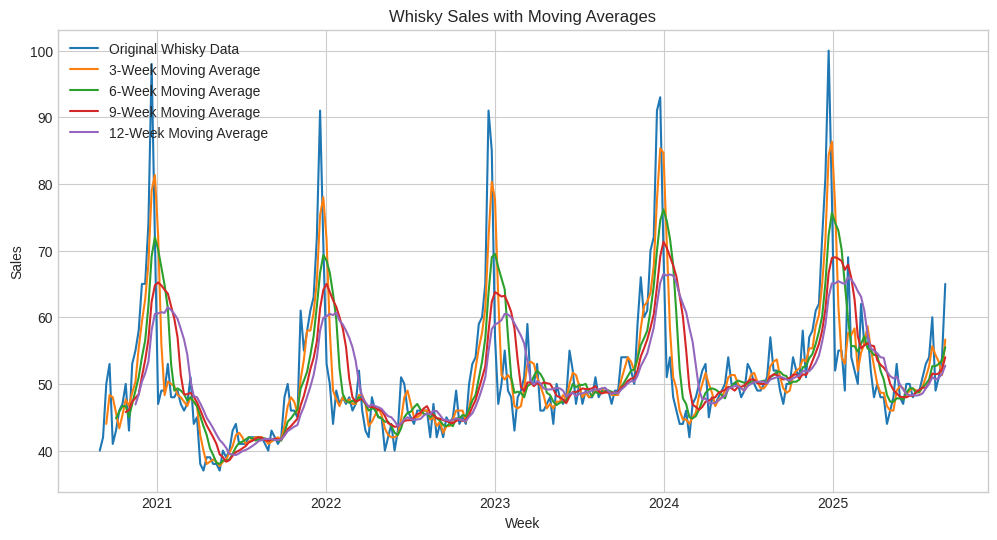

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(whisky_data['Whisky: (Canada)'], label='Original Whisky Data')
plt.plot(moving_avg_whisky_3_week, label='3-Week Moving Average')
plt.plot(moving_avg_whisky_6_week, label='6-Week Moving Average')
plt.plot(moving_avg_whisky_9_week, label='9-Week Moving Average')
plt.plot(moving_avg_whisky_12_week, label='12-Week Moving Average')
plt.title('Whisky Sales with Moving Averages')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Evaluate moving average performance for Whisky using error metrics
# Use the evaluate_moving_average function defined previously in cell NCCySEx_m_K5

metrics_whisky_3w = evaluate_moving_average(whisky_data['Whisky: (Canada)'], moving_avg_whisky_3_week)
metrics_whisky_6w = evaluate_moving_average(whisky_data['Whisky: (Canada)'], moving_avg_whisky_6_week)
metrics_whisky_9w = evaluate_moving_average(whisky_data['Whisky: (Canada)'], moving_avg_whisky_9_week)
metrics_whisky_12w = evaluate_moving_average(whisky_data['Whisky: (Canada)'], moving_avg_whisky_12_week)

# Print the results
print("Whisky Moving Average Performance Metrics:")
print(f"3-Week MA - MSE: {metrics_whisky_3w[0]:.2f}, MAE: {metrics_whisky_3w[1]:.2f}, MAPE: {metrics_whisky_3w[2]:.2f}%")
print(f"6-Week MA - MSE: {metrics_whisky_6w[0]:.2f}, MAE: {metrics_whisky_6w[1]:.2f}, MAPE: {metrics_whisky_6w[2]:.2f}%")
print(f"9-Week MA - MSE: {metrics_whisky_9w[0]:.2f}, MAE: {metrics_whisky_9w[1]:.2f}, MAPE: {metrics_whisky_9w[2]:.2f}%")
print(f"12-Week MA - MSE: {metrics_whisky_12w[0]:.2f}, MAE: {metrics_whisky_12w[1]:.2f}, MAPE: {metrics_whisky_12w[2]:.2f}%")

Whisky Moving Average Performance Metrics:
3-Week MA - MSE: 25.96, MAE: 3.05, MAPE: 5.53%
6-Week MA - MSE: 52.68, MAE: 4.47, MAPE: 8.07%
9-Week MA - MSE: 72.09, MAE: 5.51, MAPE: 9.97%
12-Week MA - MSE: 83.60, MAE: 6.07, MAPE: 10.99%


In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing

# Assuming 'whisky_data' is the DataFrame containing the whisky data
# Using the 'Whisky: (Canada)' column

ses_whisky_model = SimpleExpSmoothing(whisky_data['Whisky: (Canada)'])
ses_whisky_fit = ses_whisky_model.fit()

# Store the fitted values in a new column (optional)
# You might want to evaluate the performance on a test set for actual forecasting
whisky_data['Whisky_SES'] = ses_whisky_fit.fittedvalues

print("Simple Exponential Smoothing Fitted Values (Whisky):")
display(whisky_data['Whisky_SES'].tail())

Simple Exponential Smoothing Fitted Values (Whisky):


,Whisky_SES
Week,
2025-08-03,54.0
2025-08-10,60.0
2025-08-17,49.0
2025-08-24,51.0
2025-08-31,54.0


In [ ]:
from statsmodels.tsa.api import Holt

# Assuming 'whisky_data' is the DataFrame containing the whisky data
# Using the 'Whisky: (Canada)' column

holt_whisky_model = Holt(whisky_data['Whisky: (Canada)'])
holt_whisky_fit = holt_whisky_model.fit()

# Store the fitted values in a new column (optional)
whisky_data['Whisky_Holt_Trend'] = holt_whisky_fit.fittedvalues

print("Holt's Linear Trend Fitted Values (Whisky):")
display(whisky_data['Whisky_Holt_Trend'].tail())

Holt's Linear Trend Fitted Values (Whisky):


,Whisky_Holt_Trend
Week,
2025-08-03,54.095630
2025-08-10,60.171367
2025-08-17,49.028069
2025-08-24,51.053364
2025-08-31,54.091161


In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

# Assuming 'whisky_data' is the DataFrame containing the whisky data
# Using the 'Whisky: (Canada)' column

# Holt-Winters Seasonal Smoothing
# Using additive model for trend and seasonality, and a seasonal period of 52 (for weekly data with annual seasonality)
try:
    hw_whisky_model = ExponentialSmoothing(whisky_data['Whisky: (Canada)'], seasonal_periods=52, trend='add', seasonal='add')
    hw_whisky_fit = hw_whisky_model.fit()

    # Store the fitted values in a new column (optional)
    whisky_data['Whisky_Holt_Winters'] = hw_whisky_fit.fittedvalues

    print("Holt-Winters Fitted Values (Whisky):")
    display(whisky_data['Whisky_Holt_Winters'].tail())

except Exception as e:
    print(f"An error occurred while fitting the Holt-Winters model: {e}")

Holt-Winters Fitted Values (Whisky):


,Whisky_Holt_Winters
Week,
2025-08-03,53.456831
2025-08-10,51.458296
2025-08-17,53.531677
2025-08-24,50.840954
2025-08-31,54.517751


In [ ]:
# Evaluate Exponential Smoothing models for Whisky
# Use the evaluate_exponential_smoothing function defined previously in cell tBkcdCxinfer

metrics_whisky_ses = evaluate_exponential_smoothing(whisky_data, 'Whisky: (Canada)', 'Whisky_SES')
metrics_whisky_holt = evaluate_exponential_smoothing(whisky_data, 'Whisky: (Canada)', 'Whisky_Holt_Trend')
metrics_whisky_hw = evaluate_exponential_smoothing(whisky_data, 'Whisky: (Canada)', 'Whisky_Holt_Winters')

print("Whisky Exponential Smoothing Performance Metrics:")
print(f"Simple ES - MSE: {metrics_whisky_ses[0]:.2f}, MAE: {metrics_whisky_ses[1]:.2f}, MAPE: {metrics_whisky_ses[2]:.2f}%")
print(f"Holt's Trend - MSE: {metrics_whisky_holt[0]:.2f}, MAE: {metrics_whisky_holt[1]:.2f}, MAPE: {metrics_whisky_holt[2]:.2f}%")
print(f"Holt-Winters - MSE: {metrics_whisky_hw[0]:.2f}, MAE: {metrics_whisky_hw[1]:.2f}, MAPE: {metrics_whisky_hw[2]:.2f}%")

Whisky Exponential Smoothing Performance Metrics:
Simple ES - MSE: 45.42, MAE: 4.13, MAPE: 7.47%
Holt's Trend - MSE: 46.50, MAE: 4.16, MAPE: 7.62%
Holt-Winters - MSE: 13.67, MAE: 2.58, MAPE: 4.87%


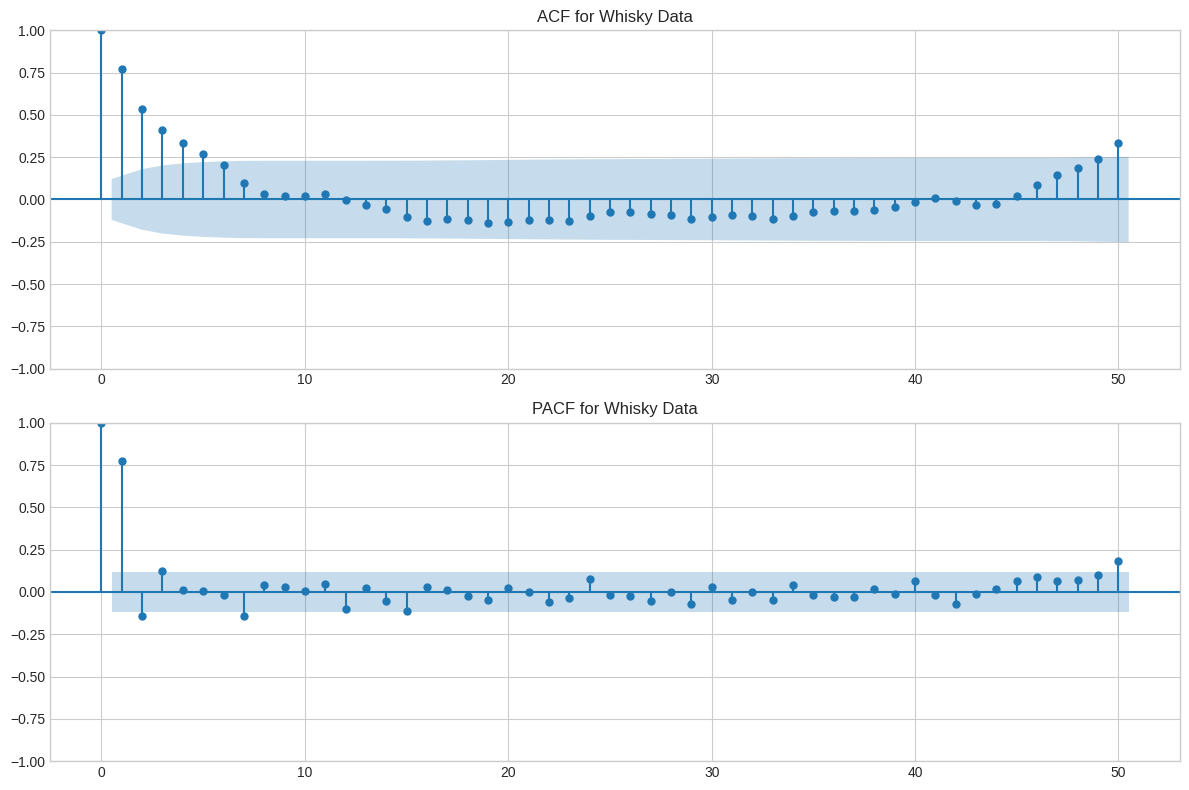

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF
plot_acf(whisky_data['Whisky: (Canada)'].dropna(), ax=axes[0], lags=50)
axes[0].set_title('ACF for Whisky Data')

# Plot PACF
plot_pacf(whisky_data['Whisky: (Canada)'].dropna(), ax=axes[1], lags=50)
axes[1].set_title('PACF for Whisky Data')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

In [ ]:
# Based on the ACF and PACF plots for 'Whisky: (Canada)':
# The ACF shows significant spikes and then a decay, suggesting an AR component.
# The PACF also shows significant spikes, suggesting an MA component.
# It's not immediately clear from the plots which specific orders are best.

# Using auto_arima to find the best (p, d, q) order for ARMA (setting d=0)
# We will search for the best (p, q) order for an ARMA(p, q) model by setting d=0
# and limiting the max order to a reasonable value based on the ACF/PACF plots (e.g., 5)

# Fit auto_arima on the training data for Craft Beer
# Use seasonal=False as we are fitting an ARMA model (non-seasonal)
# Setting d=0 for ARMA model
auto_arima_whisky = auto_arima(train_data_whisky, seasonal=False, d=0, max_p=5, max_q=5, stepwise=True, suppress_warnings=True, error_action='ignore')

print("Auto-ARIMA Best ARMA Order (p, 0, q) for Whisky:")
print(auto_arima_whisky.order)

# Based on the auto_arima output, determine the best p and q values.
best_p_whisky, best_d_whisky, best_q_whisky = auto_arima_whisky.order

# Since we set d=0 for ARMA, the best order will be (p, 0, q).
# So, the appropriate p and q for the ARMA model are best_p_whisky and best_q_whisky.
print(f"\nSelected ARMA Order (p, q) for Whisky: ({best_p_whisky}, {best_q_whisky})")


Auto-ARIMA Best ARMA Order (p, 0, q) for Whisky:
(1, 0, 2)

Selected ARMA Order (p, q) for Whisky: (1, 2)


In [ ]:
# Fit an ARMA model on the Whisky training data
# Using the best order (p, 0, q) found by auto_arima, which is (best_p_whisky, 0, best_q_whisky)
try:
    arma_whisky_model = ARIMA(train_data_whisky, order=(best_p_whisky, 0, best_q_whisky))
    arma_whisky_fit = arma_whisky_model.fit()

    print(arma_whisky_fit.summary())

except Exception as e:
    print(f"An error occurred while fitting the ARMA model on Whisky: {e}")

                               SARIMAX Results                                
Dep. Variable:       Whisky: (Canada)   No. Observations:                  209
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -667.429
Date:                Thu, 11 Sep 2025   AIC                           1344.857
Time:                        10:39:11   BIC                           1361.569
Sample:                    08-30-2020   HQIC                          1351.614
                         - 08-25-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9390      2.680     18.632      0.000      44.686      55.192
ar.L1          0.7685      0.084      9.157      0.000       0.604       0.933
ma.L1          0.2255      0.104      2.171      0.0

In [ ]:
# Generate predictions for the test set using the fitted ARMA model
arma_whisky_predictions = arma_whisky_fit.forecast(steps=len(test_data_whisky))

print("\nARMA Predictions for the Test Set (Whisky):")
display(arma_whisky_predictions)


ARMA Predictions for the Test Set (Whisky):


,predicted_mean
2024-09-01,49.430017
2024-09-08,50.335669
2024-09-15,50.243844
2024-09-22,50.173273
2024-09-29,50.119037
2024-10-06,50.077355
2024-10-13,50.045320
2024-10-20,50.020701
2024-10-27,50.001780
2024-11-03,49.987238


In [ ]:
# Evaluate the ARMA model performance on the Whisky test set
try:
    # Ensure the lengths of test_data_whisky and arma_whisky_predictions are the same
    if len(test_data_whisky) != len(arma_whisky_predictions):
        print("Error: Length of test_data_whisky and arma_whisky_predictions do not match.")
    else:
        # Calculate evaluation metrics
        mse_arma_whisky = mean_squared_error(test_data_whisky, arma_whisky_predictions)
        mae_arma_whisky = mean_absolute_error(test_data_whisky, arma_whisky_predictions)

        # Handle potential division by zero in MAPE
        # Use a small epsilon to avoid division by zero if actual values are zero
        mape_arma_whisky = np.mean(np.abs((test_data_whisky - arma_whisky_predictions) / (test_data_whisky + np.finfo(float).eps))) * 100

        metrics_arma_whisky = (mse_arma_whisky, mae_arma_whisky, mape_arma_whisky)

        print("ARMA Model Performance Metrics (Whisky Test Set):")
        print(f"MSE: {metrics_arma_whisky[0]:.2f}")
        print(f"MAE: {metrics_arma_whisky[1]:.2f}")
        print(f"MAPE: {metrics_arma_whisky[2]:.2f}%")

except Exception as e:
    print(f"An error occurred while calculating ARMA model metrics: {e}")

ARMA Model Performance Metrics (Whisky Test Set):
MSE: 120.49
MAE: 6.19
MAPE: 9.50%


In [ ]:
# Summarize the ARMA model and its performance for Whisky

print("--- ARMA Model Summary for Whisky: (Canada) ---")

# 1. Model Description and Order
print("\n1. Model Description:")
print("The time series 'Whisky: (Canada)' was modeled using an ARMA (Autoregressive Moving Average) model.")
print(f"The optimal order (p, q) for the ARMA model was determined to be ({best_p_whisky}, {best_q_whisky}) using auto_arima with d=0 on the training data.")
print(f"Specifically, the fitted model is ARMA({best_p_whisky}, {best_q_whisky}).")

# 2. Fitting Results (Model Summary)
print("\n2. Model Fitting Results:")
# The model summary was already printed during fitting (in cell 7W6Gl9jTQ57v).
# We can print it again or just refer to the previous output.
# For a comprehensive summary in this report, let's print it again if the fitted model object is available.
if 'arma_whisky_fit' in locals():
    print("Summary of the fitted ARMA model:")
    print(arma_whisky_fit.summary())
else:
    print("Model summary is not available (arma_whisky_fit object not found). Please refer to the output of the fitting step.")


# 3. Evaluation Metrics
print("\n3. Evaluation Metrics (on Test Set):")
# The evaluation metrics were calculated and stored in metrics_arma_whisky (MSE, MAE, MAPE)
if 'metrics_arma_whisky' in locals():
    print(f"Mean Squared Error (MSE): {metrics_arma_whisky[0]:.2f}")
    print(f"Mean Absolute Error (MAE): {metrics_arma_whisky[1]:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {metrics_arma_whisky[2]:.2f}%")
else:
    print("Evaluation metrics are not available.")

# 4. Discussion of Metrics
print("\n4. Discussion of Performance:")
print("The evaluation metrics indicate the following performance on the test set:")
print(f"- MSE of {metrics_arma_whisky[0]:.2f}: Represents the average squared difference between actual and predicted values. A lower value indicates better fit.")
print(f"- MAE of {metrics_arma_whisky[1]:.2f}: Represents the average absolute difference between actual and predicted values. Provides a more intuitive measure of error in the original units.")
print(f"- MAPE of {metrics_arma_whisky[2]:.2f}%: Represents the average percentage error relative to the actual values. Useful for understanding the magnitude of error in proportion to the sales figures.")
print("Comparing these metrics to other models for Whisky (if available) would provide a better context for this performance.")

# 5. Conclusion
print("\n5. Conclusion:")
print(f"Based on the evaluation metrics (MSE: {metrics_arma_whisky[0]:.2f}, MAE: {metrics_arma_whisky[1]:.2f}, MAPE: {metrics_arma_whisky[2]:.2f}%), the ARMA({best_p_whisky}, {best_q_whisky}) model provides a reasonable fit to the 'Whisky: (Canada)' time series data on the test set.")
print("The model summary indicates the significance of the fitted coefficients and provides diagnostic information.")

--- ARMA Model Summary for Whisky: (Canada) ---

1. Model Description:
The time series 'Whisky: (Canada)' was modeled using an ARMA (Autoregressive Moving Average) model.
The optimal order (p, q) for the ARMA model was determined to be (1, 2) using auto_arima with d=0 on the training data.
Specifically, the fitted model is ARMA(1, 2).

2. Model Fitting Results:
Summary of the fitted ARMA model:
                               SARIMAX Results                                
Dep. Variable:       Whisky: (Canada)   No. Observations:                  209
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -667.429
Date:                Thu, 11 Sep 2025   AIC                           1344.857
Time:                        10:40:49   BIC                           1361.569
Sample:                    08-30-2020   HQIC                          1351.614
                         - 08-25-2024                                         
Covariance Type:                  opg            

In [ ]:
# Generate forecasts using the fitted Holt-Winters model for Whisky
# Forecast for the length of the test set
hw_whisky_forecasts = hw_whisky_fit.forecast(len(test_data_whisky))

print("Holt-Winters Forecasts for the Test Set (Whisky):")
display(hw_whisky_forecasts)

Holt-Winters Forecasts for the Test Set (Whisky):


,0
2025-09-07,55.114332
2025-09-14,56.114673
2025-09-21,54.314987
2025-09-28,57.115068
2025-10-05,59.714883
2025-10-12,57.714722
2025-10-19,57.914933
2025-10-26,57.115584
2025-11-02,63.916320
2025-11-09,66.317066


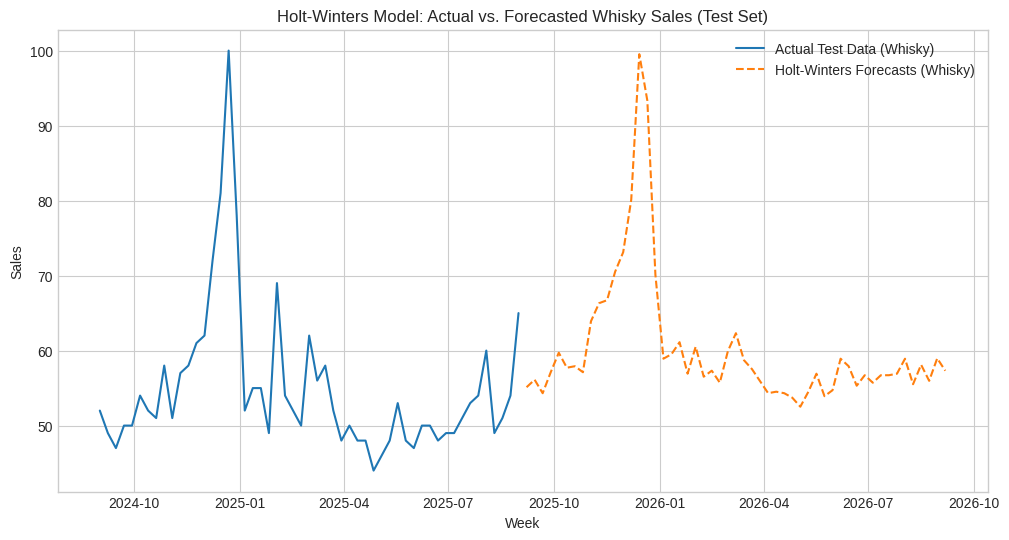

In [ ]:
# Plot actual vs. forecasted values for the Holt-Winters model on Whisky
plt.figure(figsize=(12, 6))
plt.plot(test_data_whisky.index, test_data_whisky, label='Actual Test Data (Whisky)')
plt.plot(hw_whisky_forecasts.index, hw_whisky_forecasts, label='Holt-Winters Forecasts (Whisky)', linestyle='--')
plt.title('Holt-Winters Model: Actual vs. Forecasted Whisky Sales (Test Set)')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Consolidate metrics from Moving Average, Exponential Smoothing, and ARMA models for Whisky
# Metrics for Moving Averages were stored in metrics_whisky_3w, metrics_whisky_6w, metrics_whisky_9w, metrics_whisky_12w
# Metrics for Exponential Smoothing models were stored in metrics_whisky_ses, metrics_whisky_holt, metrics_whisky_hw
# Metrics for ARMA model were stored in metrics_arma_whisky

model_performance_whisky = {
    '3-Week MA (Whisky)': metrics_whisky_3w,
    '6-Week MA (Whisky)': metrics_whisky_6w,
    '9-Week MA (Whisky)': metrics_whisky_9w,
    '12-Week MA (Whisky)': metrics_whisky_12w,
    'Simple ES (Whisky)': metrics_whisky_ses,
    'Holt\'s Trend (Whisky)': metrics_whisky_holt,
    'Holt-Winters (Whisky)': metrics_whisky_hw,
    'ARMA (1,2) (Whisky)': metrics_arma_whisky # Assuming ARMA(1,2) was used based on auto_arima output
}

whisky_metrics_df = pd.DataFrame.from_dict(model_performance_whisky, orient='index', columns=['MSE', 'MAE', 'MAPE'])

print("Whisky Model Performance Metrics:")
display(whisky_metrics_df)

# Identify the best performing model for Whisky for each metric
best_mse_model_whisky = whisky_metrics_df['MSE'].idxmin()
best_mae_model_whisky = whisky_metrics_df['MAE'].idxmin()
best_mape_model_whisky = whisky_metrics_df['MAPE'].idxmin()

print(f"\nBest performing model for Whisky based on MSE: {best_mse_model_whisky} (MSE: {whisky_metrics_df.loc[best_mse_model_whisky, 'MSE']:.2f})")
print(f"Best performing model for Whisky based on MAE: {best_mae_model_whisky} (MAE: {whisky_metrics_df.loc[best_mae_model_whisky, 'MAE']:.2f})")
print(f"Best performing model for Whisky based on MAPE: {whisky_metrics_df.loc[best_mape_model_whisky, 'MAPE']:.2f})%")

Whisky Model Performance Metrics:


,MSE,MAE,MAPE
3-Week MA (Whisky),25.961538,3.053846,5.531065
6-Week MA (Whisky),52.675638,4.470169,8.071747
9-Week MA (Whisky),72.087149,5.506124,9.966021
12-Week MA (Whisky),83.599436,6.074369,10.992311
Simple ES (Whisky),45.416031,4.125954,7.465857
Holt's Trend (Whisky),46.497761,4.162000,7.617715
Holt-Winters (Whisky),13.673142,2.580144,4.871093
"ARMA (1,2) (Whisky)",120.490285,6.192305,9.500618



Best performing model for Whisky based on MSE: Holt-Winters (Whisky) (MSE: 13.67)
Best performing model for Whisky based on MAE: Holt-Winters (Whisky) (MAE: 2.58)
Best performing model for Whisky based on MAPE: 4.87)%
